In [1]:
import requests
import json
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import itertools
from itertools import product
import random


In [2]:
df = pd.read_csv('../data/spotify_dataset.csv', usecols=range(4), lineterminator='\n', header=0)

In [3]:
df.columns = [x.replace('"', '').lstrip() for x in df.columns]

In [4]:
playlists = df['playlistname'].unique()
print('Number of Playlists:', len(playlists))
print('Number of Artists:', len(df['artistname'].unique()))

Number of Playlists: 161530
Number of Artists: 290002


#### Problem:
- Networkx takes too much time to load up a graph with all the data <br>
- In ~5 min we can retrieve 2000 artist genres


#### Potential Solution:
- Sample 1,000 playlists
- See if there is a sufficient amount of artists and playlist appearances

In [5]:
sample_playlists = np.random.choice(playlists, 5000, replace=False)
sampled_df = df[df['playlistname'].isin(sample_playlists)]

In [6]:
print('Number of songs in sample:', len(sampled_df))
print('Number of Artists:', len(sampled_df['artistname'].unique()))

Number of songs in sample: 362592
Number of Artists: 35234


In [7]:
appearances = sampled_df.groupby('artistname').agg({'trackname':'count', 'playlistname':lambda x: len(x.unique())})
appearances.sort_values(by=['trackname', 'playlistname'])

,trackname,playlistname
artistname,,
#1 Disco Dance Hits,1,1
#1 Garth Brooks Tribute Band,1,1
'80s Soundtrack Players,1,1
'Nsync,1,1
( www.Top3Da.Net ),1,1
...,...,...
Eminem,1074,115
Frank Sinatra,1204,53
The Rolling Stones,1261,120


- There are some artists that appear on an insignificant amount of playlists, define this to be anything less than 10

In [8]:
artists = appearances[appearances['playlistname']>=10].index
print('# of artists on >= 10 playlists (sample):', len(artists))

# of artists on >= 10 playlists (sample): 2038


In [9]:
df1 = sampled_df[sampled_df['artistname'].isin(artists)]
df1

,user_id,artistname,trackname,playlistname
1591,944c80d26922ae634d6ce445b1fdff7f,Counting Crows,Accidentally In Love,2014 beginning
1595,944c80d26922ae634d6ce445b1fdff7f,Daniel Powter,Bad Day,2014 beginning
1596,944c80d26922ae634d6ce445b1fdff7f,Babyshambles,Baddies Boogie,2014 beginning
1598,944c80d26922ae634d6ce445b1fdff7f,Barenaked Ladies,Big Bang Theory Theme,2014 beginning
1599,944c80d26922ae634d6ce445b1fdff7f,Eliza Doolittle,Big When I Was Little,2014 beginning
...,...,...,...,...
12899962,8d27d5741b3210e41ab3a499c1141af9,Klingande,Jubel - Original Mix,Music for Luch/Lounge vol.4
12899971,8d27d5741b3210e41ab3a499c1141af9,Mr Little Jeans,Oh Sailor - My Great Ghost Remix,Music for Luch/Lounge vol.4
12899973,8d27d5741b3210e41ab3a499c1141af9,YACHT,Psychic City (Classixx Remix),Music for Luch/Lounge vol.4
12899983,8d27d5741b3210e41ab3a499c1141af9,Parov Stelar,The Princess,Music for Luch/Lounge vol.4


- Only take playlists that have more than 1 artist (otherwise there's no edge)

In [10]:
df1_grped = df1.groupby('playlistname').agg({'artistname':lambda x: len(x.unique())})
playlists = df1_grped[df1_grped['artistname'] > 1].index

In [11]:
df2 = df1[df1['playlistname'].isin(playlists)]
df

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010
...,...,...,...,...
12901974,2302bf9c64dc63d88a750215ed187f2c,Mötley Crüe,Wild Side,iPhone
12901975,2302bf9c64dc63d88a750215ed187f2c,John Lennon,Woman,iPhone
12901976,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Don't Know How It Feels,iPhone
12901977,2302bf9c64dc63d88a750215ed187f2c,Tom Petty,You Wreck Me,iPhone


In [12]:
# same def as quarter 1
def read_edge(gph, n0, n1):
    if gph.has_edge(n0, n1):
        gph[n0][n1]['weight'] +=1
        return gph[n0][n1]['weight']
    else:
        gph.add_edge(n0, n1, weight=1)
        return 1

In [13]:
%%time
G = nx.Graph()
# if not unique, could weight the number of times the artist appears in that playlist
df2_grp = df2.groupby('playlistname').agg({'artistname': lambda x: (x).unique()})

for i in range(len(df2_grp)):
    
    for a in (df2_grp.iloc[i]):
        for a1, a2 in itertools.combinations(a, 2):
            read_edge(G, a1, a2)


CPU times: user 6.46 s, sys: 159 ms, total: 6.62 s
Wall time: 6.65 s


CPU times: user 54.3 s, sys: 797 ms, total: 55.1 s
Wall time: 55.1 s


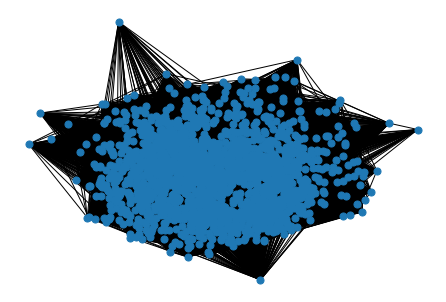

In [14]:
%%time
nx.draw(G, node_size=50)


In [15]:
G.size()

1244470

In [16]:
weight_dict = {}
node_weights = nx.get_edge_attributes(G, "weight")
for i in node_weights:
    if 'Vampire Weekend' in i:
        weight_dict[i] = node_weights[i]

In [17]:
sorted(weight_dict.items(), key=lambda x:x[1], reverse=True)

[(('Vampire Weekend', 'Phoenix'), 35),
 (('Vampire Weekend', 'Daft Punk'), 31),
 (('Arctic Monkeys', 'Vampire Weekend'), 28),
 (('Vampire Weekend', 'MGMT'), 28),
 (('Vampire Weekend', 'Two Door Cinema Club'), 27),
 (('The Strokes', 'Vampire Weekend'), 26),
 (('Vampire Weekend', 'The Killers'), 26),
 (('Vampire Weekend', 'Coldplay'), 25),
 (('Vampire Weekend', 'Arcade Fire'), 23),
 (('Vampire Weekend', 'The Black Keys'), 22),
 (('Vampire Weekend', 'Foster The People'), 22),
 (('Vampire Weekend', 'Radiohead'), 22),
 (('Vampire Weekend', 'M83'), 22),
 (('Vampire Weekend', 'Mumford & Sons'), 22),
 (('Vampire Weekend', 'The Kooks'), 21),
 (('Vampire Weekend', 'Passion Pit'), 21),
 (('Vampire Weekend', 'Yeah Yeah Yeahs'), 21),
 (('Vampire Weekend', 'The National'), 21),
 (('Vampire Weekend', 'LCD Soundsystem'), 20),
 (('Vampire Weekend', 'Florence + The Machine'), 20),
 (('Vampire Weekend', 'Kanye West'), 20),
 (('Vampire Weekend', 'Kings Of Leon'), 19),
 (('Vampire Weekend', 'The xx'), 18),

In [18]:
len(G.nodes)

2038